# M6 Team Assignment: Spooky Authorship With Spark Part 2

#### Group 13
- Aidan Lonergan
- Daniel Lillard
- Radhika Garg
- Claudine Uwiragiye

## Objective
- In this assignment, your team will improve your scores from the first Spooky Authorship assignment. Your goal should be to get at least a 80% accuracy. If you already have over 80% accuracy, aim to get 85% accuracy. 

<hr>

### Stage 0 - Import Data

In [11]:
# Stage 0 Solution
from pyspark.sql import SparkSession
import pandas as pd

# Start spark session and load train and test data sets
spark = SparkSession.builder \
    .appName("Module_5_Project") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.python.worker.memory", "1g") \
    .config("spark.executor.pyspark.memory", "2g") \
    .config("spark.rpc.io.connectionTimeout", "30s") \
    .getOrCreate()

df_train = spark.read.csv('./train.csv', header=True, inferSchema=True, quote='"', escape='"')
print(df_train.show())

+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
|id22965|A youth passed in...|   MWS|
|id09674|The astronomer, p...|   EAP|
|id13515|The surcingle hun...|   EAP|
|id19322|I knew that you c...|   EAP|
|id00912|I confess that ne...|   MWS|
|id16737|He shall find tha...|   MWS|
|id16607|Here we barricade...|   EAP|
|id19764|Herbert West need...|   HPL|
|id18886|The farm like gro...|   HPL|
|id17189|But a glance will...|   EAP|
|id12799|He had escaped me...|   MWS|
|id08441|To these speeches...|   EAP|
|id13117|Her native sprigh...|   MWS|
|id14862|I even went so fa...|   EAP|
|id20836|His facial aspect...|   HPL|
+-------+--------------------+------+
only showing top 20 rows
None


<hr>

### Stage 1 - Data Preparation

In [12]:
# Step 1 - Preprocessing
from pyspark.sql.functions import col, split, explode, lower, regexp_replace, udf, collect_list, first, pandas_udf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pyspark.sql.types import StringType, ArrayType

# Get stop words
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Clean and lowercase text, remove punctuation
df_train_cleaned = df_train.withColumn("clean_text", lower(regexp_replace(col("text"), r"[^a-zA-Z0-9\s]", "")))

# Tokenize into words then filter out empty strings after tokenization
df_train_words = df_train_cleaned.withColumn("word", explode(split(col("clean_text"), r"\s+"))).filter(col('word') != "")

# Remove stop words
df_train_filtered = df_train_words.filter(~col("word").isin(stop_words))

#tokens = word_tokenize(df_train_filtered)
#df_train_filtered = [lemmatizer.lemmatize(word) for word in tokens]

# Define UDF
def lemmatize_text(text):
    if text:
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

lemmatize_udf = udf(lemmatize_text, StringType())
df_train_filtered_lem = df_train_filtered.withColumn("text", lemmatize_udf(col("text"))) # Apply UDF to the column

# Aggregate words into list per id, author (currently they are a single field per row) and retain text column
df_grouped = df_train_filtered_lem.groupBy("id", "author").agg(
    collect_list("word").alias("words"),
    first('clean_text').alias('clean_text')
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z004spjy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\z004spjy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<hr>

### Stage 2 - Feature Extraction

In [13]:
# Stage 2 - TFIDF and Normalization 
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Normalizer

# Compute HashingTF
hashingTF = HashingTF(inputCol='words', outputCol='tf', numFeatures=4096) # I selected 4096 for no particular reason, this can be tweaked.                           
tf_data_train = hashingTF.transform(df_grouped)

# Compute IDF
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=3)
idf_model_train = idf.fit(tf_data_train)
tfidf_data_train = idf_model_train.transform(tf_data_train)

# Normalize the data
normalizer = Normalizer(inputCol='tfidf', outputCol='tfidf_norm', p=2.0)
tfidf_data_train = normalizer.transform(tfidf_data_train)

# Drop unneeded columns and show a few rows
tfidf_data_train = tfidf_data_train.drop('tf', 'words')
tfidf_data_train.select('tfidf').show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tfidf                                                                                                                                                                                       

<hr>

### Stage 3 - Machine Learning
1) Perform train/test split
2) Train neural network to achieve >85% accuracy

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train test split
train_data, test_data = tfidf_data_train.randomSplit([0.7, 0.3], seed=42)
train_data.cache()
test_data.cache()

# Convert author labels to numeric index
indexer = StringIndexer(inputCol='author', outputCol='label')
indexer_model = indexer.fit(train_data)
indexed_train = indexer_model.transform(train_data)
indexed_test = indexer_model.transform(test_data)
indexed_train.cache()
indexed_train.count() # Force the train data to cache

layers = [hashingTF.getNumFeatures(), 200, 100, 50, 3]

# create the trainer and set its parameters
nn_trainer = MultilayerPerceptronClassifier(maxIter=150, layers=layers, stepSize= 0.03, blockSize=128, seed=1234,featuresCol='tfidf_norm',labelCol='label')

nn_pipeline = Pipeline(stages=[
    indexer
    ,nn_trainer
])

# Fit and transform using same pipeline
nn_model = nn_pipeline.fit(train_data)
nn_results = nn_model.transform(train_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='accuracy'
)

accuracy = evaluator.evaluate(nn_results)
print(f'Training Accuracy: {accuracy:.4f}')

Training Accuracy: 0.8631


<hr>

### Stage 4 - Evaluation and Visualization

Neural Network Accuracy Score: 0.7017104092226326


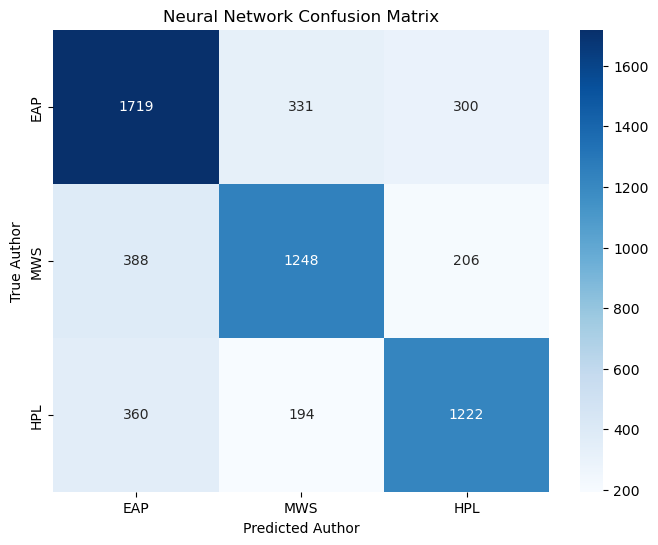

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

label_mapping = indexer_model.labels  # Get mapping of indices to author names for analysis (e.g., ['EAP', 'HPL', 'MWS'])
test_data_nn = test_data.drop('label')
nn_test_predictions = nn_model.transform(test_data_nn)

nn_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
acc_score = nn_evaluator.evaluate(nn_test_predictions)
print(f"Neural Network Accuracy Score: {acc_score}")

# Get confusion matrix
nn_test_predictions = nn_test_predictions.select('label', 'prediction').toPandas()
nn_conf_mat = confusion_matrix(nn_test_predictions['label'], nn_test_predictions['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(nn_conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.show()